<a href="https://colab.research.google.com/github/khadijaraza/spisproject/blob/main/trainingclassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

In [32]:
#mapping target numbers to actual class names for celestial object classification
class_map = {
    90: "Type Ia Supernova",
    67: "Type Ia Supernova - Old ",
    52: "Type Ia Supernova - New",
    62: "Type Ib/c Supernova",
    42: "Type 2 Supernova",
    95: "Superluminous Supernova",
    65: "Red Dwarf Stellar Flare",
    16: "Eclipsing Binary Stars",
    15: "Tidal Disruption Event",
    88: "Active Galactic Nuclei",
    92: "RR Lyrae Variable Star",
    6: "Unknown Compact Object",
    64: "Kilonova",
    53: "Mira Variables",
}

In [33]:
#reading csv files
lc_df = pd.read_csv("training_set.csv")
meta_df = pd.read_csv("training_set_metadata.csv")
#print(meta_df.info())

#making a folder storing stitched files
folder = "stitched_lc"
os.makedirs(folder, exist_ok=True)

#finding all unique object ID's
obj_ids = lc_df["object_id"].unique()

#making sure each lc corresponds to one object ID, aka stitching
for id in tqdm(obj_ids, desc="stitching objects..."):
  obj_lc = lc_df[lc_df["object_id"] == id].sort_values("mjd")
  obj_lc = obj_lc[obj_lc["detected"] == 1]
  output_file = os.path.join(folder, f"obj_{id}.csv") #saving current object id.csv in the designated stitched lc's folder
  obj_lc.to_csv(output_file, index=False)

meta_df.to_csv("training_set_metadatacopy.csv", index=False)
print("Finished stitching light curves")

stitching objects...: 100%|██████████| 7848/7848 [00:46<00:00, 167.14it/s]

Finished stitching light curves


In [34]:
metacopy_df = pd.read_csv("training_set_metadatacopy.csv")

#print(metacopy_df.columns)
#print(metacopy_df.head())

def getFeatures(file_path):
  df = pd.read_csv(file_path)
  flux = df["flux"].values

  features = {
      "mean_flux": np.mean(flux),
      "std_flux": np.std(flux),
      "amplitude": np.max(flux) - np.min(flux),
      "median_flux": np.median(flux),
      "flux_skew": skew(flux),
      "flux_kurtosis": kurtosis(flux),
      "flux_p25": np.percentile(flux, 25),
      "flux_p75": np.percentile(flux, 75),
      "flux_range_50": np.percentile(flux, 75) - np.percentile(flux, 25)
  }

  return features

feature_list = []
for name in os.listdir(folder): #iterates through lc csv's in the stiched_lc folder
  if name.endswith(".csv"):
        obj_id = int(name.replace(".csv", "").replace("obj_", "")) #object ID is extracted from each file name
        feats = getFeatures(os.path.join(folder, name))
        feats["object_id"] = obj_id
        feature_list.append(feats)

features_df = pd.DataFrame(feature_list)
data = features_df.merge(meta_df[["object_id", "target"]], on="object_id")
data["class_name"] = data["target"].map(class_map)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           6       0.56      0.29      0.38        31
          15       0.26      0.14      0.18       106
          16       0.89      0.88      0.89       198
          42       0.34      0.28      0.30       256
          52       0.25      0.03      0.05        38
          53       1.00      0.67      0.80         6
          62       0.10      0.03      0.05        92
          64       0.00      0.00      0.00        19
          65       0.57      0.56      0.56       183
          67       0.00      0.00      0.00        40
          88       0.63      0.44      0.52        77
          90       0.45      0.75      0.57       455
          92       0.84      0.97      0.90        38
          95       0.00      0.00      0.00        31

    accuracy                           0.51      1570
   macro avg       0.42      0.36      0.37      1570
weighted avg       0.46      0.51      0.47      1570



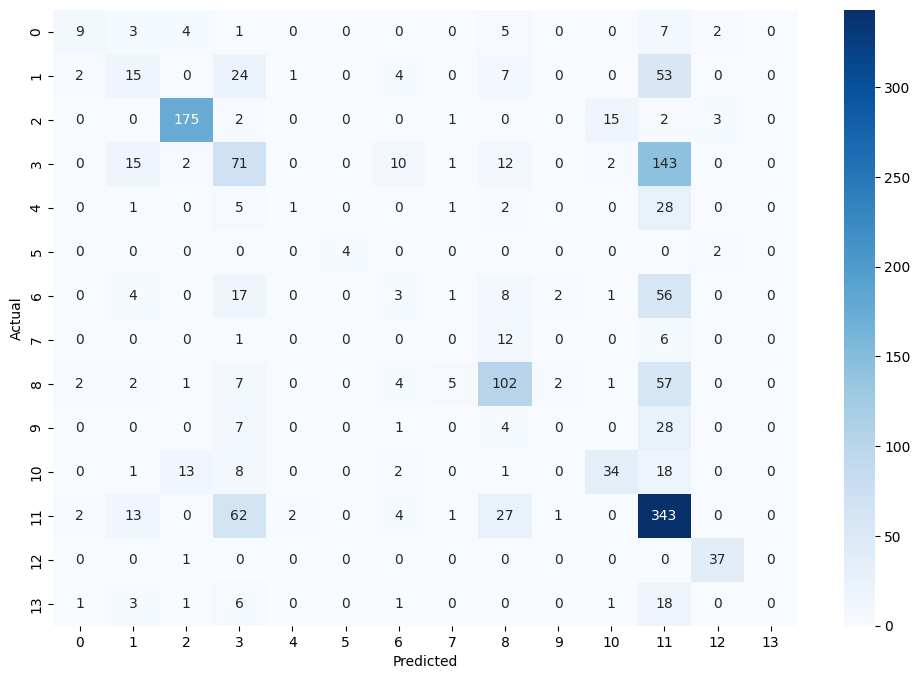

In [35]:
x = data.drop(columns=["object_id", "target", "class_name"])
y = data["target"]

#SMOTE will handle the rarer supernovae/classes as minorities are underrepresented in ML models
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(
    n_estimators=300,        # number of trees
    class_weight="balanced", # handles rare classes
    random_state=42,         # reproducibility
    n_jobs=-1                # use all CPU cores (faster)
)
clf.fit(X_train, y_train)

#predictions
y_pred = clf.predict(X_test)

#classification report
print(classification_report(y_test, y_pred))

#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()